<a href="https://colab.research.google.com/github/kingwmoon/kingwmoon-Hurricanes-Tracks-And-Their-Economic-Impacts-in-a-Changing-Climate/blob/main/final_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hurricanes tracks and their economic impacts in a changing climate

We have all been affected by hurricanes. Even just this past summer when Hurricane Ida hit the United States, Kate’s family was hit in New Orleans and she, George, Haoyue, and Muji were all hit by Hurricane Ida in New York. In just a few days, Hurricane Ida in NYC stopped our travel, killed at least 16 people, and “easily surpassed the $30 million threshold required for… a so-called major disaster declaration” (Newman, 2021). Across the country from New York City, New Orleans is still recovering from Ida in February. Some businesses are still closed and many residential roofs still need to be replaced (McNulty, 2022). 

Seeing all of this hurricane damage across the country begs the question, what kind of economic impacts do these storm tracks have, and have these impacts been rising with a relationship to the changing climate? The goal of this analysis is to try and identify financially damaging hurricanes based off natural factors of their landfall. 




## Section 1: Initializing data and cleaning
In this section, we load the relevant libraries and modules and clean the data. Some processing is done to get the distance travelled by the hurricane, and another dataset is referenced for monthly sea surface temperature anomalies in the tropical Atlantic.

The datasets used:
- Hurricane data: IBTrACS version 04 (Knapp et al., 2010)
- Sea surface temperature data: Extended Reconstructed SST (Huang et al., 2017)

In [ ]:
#@title Make data folder
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [ ]:
#@title Install libraries
%%capture
# These uninstallation must be done to ensure that no version conflicts would happen.
!pip uninstall --yes cartopy 
!pip uninstall --yes shapely
# Shapely and cartopy are used for graphing maps and tracks.
!pip install shapely cartopy --no-binary shapely --no-binary cartopy


In [ ]:
#@title Import libraries and modules
import cartopy.crs as ccrs # used for map projection
import matplotlib.pyplot as plt # matplotlib
import cartopy.feature as cfeature # used for map projection
import xarray as xr # x-array 
import numpy as np # numpy
import pandas as pd
import urllib.request # download request
import warnings # to suppress warnings
from numpy import linalg as LA # to plot the moments (by calculating the eigenvalues)
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.cluster import k_means # to perform k-means
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

from collections import Counter # set operations
warnings.filterwarnings('ignore')

In [ ]:
#@title Download datasets
# Download the relevant datasets

# Hurricane data
filedata = urllib.request.urlopen('https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/netcdf/IBTrACS.NA.v04r00.nc')
datatowrite = filedata.read()
 
with open('/content/data/NA_data.nc', 'wb') as f:
    f.write(datatowrite)

tks = xr.open_dataset('data/NA_data.nc', engine="netcdf4", decode_times=False)

# Sea surface temperature data
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1854', '2022')).load()
basin = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NODC/.WOA09/.Masks/.basin/dods')
basin = basin.rename({'X': 'lon', 'Y': 'lat'})
basin_surf = basin.basin[0]
basin_surf_interp = basin_surf.interp_like(ds.sst, method='nearest')
Atlantic_sst = ds.sst.groupby(basin_surf_interp)[1]
tropical_sst = Atlantic_sst.where(abs(Atlantic_sst.lat)<=20,drop=True) 
mean_tropical_sst = tropical_sst.mean(dim='stacked_lat_lon')
gb = mean_tropical_sst.groupby('time.month')
anom = gb - gb.mean(dim='time')

In [ ]:
#@title Initialize helper functions

# Create map plot background
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                      edgecolor='face', 
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face', 
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax

# Function for lon lat extraction of storm on land
def get_lon_lat(storm):
  lon_lst = storm.lon.values
  lat_lst = storm.lat.values
  return lon_lst[~np.isnan(lon_lst)], lat_lst[~np.isnan(lat_lst)]

# Formula to get distance between pair of latitudes and longitudes
# Based off Haversine formula for great circle distance
def get_dist_two_points(lon1,lon2,lat1,lat2):
  r_e_km = 6378.1 # km, from https://arxiv.org/pdf/1510.07674.pdf
  # convert lon,lat to degrees and get difference
  lat1 = lat1*np.pi/180 # need in later equation
  lat2 = lat2*np.pi/180 # need in later equation
  d_lon = (lon2-lon1)*np.pi/180  
  d_lat = lat2-lat1
  d = 2*r_e_km*np.arcsin(np.sqrt(np.sin(d_lat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(d_lon/2)**2))
  return d

# Function to get total distance storm travelled on land (km)
def get_distance(storm):
  lon_lst, lat_lst = get_lon_lat(storm)
  on_land_list = storm.dist2land[~np.isnan(storm.dist2land)]
  dist = 0
  for i in range(len(lon_lst)-1):
    if on_land_list[i]== 0 and on_land_list[i+1]== 0:
      dist += get_dist_two_points(lon_lst[i],lon_lst[i+1],lat_lst[i],lat_lst[i+1])
  return dist

# Function to get total time travelled (days)
def get_time(storm):
  time_list  = storm.time[~np.isnan(storm.time)]
  on_land_list = storm.dist2land[~np.isnan(storm.dist2land)]
  total_time = 0
  for i in range(len(time_list)-1):
    if on_land_list[i]== 0 and on_land_list[i+1]== 0:
      total_time += time_list[i+1]-time_list[i]
  return total_time

# Function to get positive values
def pos(lst):
    return [x for x in lst if x >= 0] or None

# Function to gain the windspeed of landfall
def get_windspeed_landfall(storm):
  wind_speed = pos(storm.usa_sshs.values[storm.dist2land.values==0])
  if wind_speed != None:
     return  np.min(wind_speed),np.mean(wind_speed),np.max(wind_speed)
  else:
    return 0,0,0

# Function to get the month for landfall
def get_month_landfall(storm):
  month = 0
  if len(storm.iso_time.values[storm.dist2land.values==0])>0:
    date = storm.iso_time.values[storm.dist2land.values==0][0]
    month = int(date[5:7])
  return month

# Function to get initial lat, lon, windspeed of landing location
def get_data_of_initial_landing(storm):
  lat_landfall = 0
  lon_landfall = 0
  init_windspeed = 0
  if len(storm.lat.values[storm.dist2land.values==0])>0:
    lat_landfall = storm.lat.values[storm.dist2land.values==0][0]
    lon_landfall = storm.lon.values[storm.dist2land.values==0][0]
    if storm.usa_sshs.values[storm.dist2land.values==0][0] > 0:
      init_windspeed = storm.usa_sshs.values[storm.dist2land.values==0][0]
  return lat_landfall, lon_landfall, init_windspeed

In [ ]:
#@title Clean data (takes a long time)
dist_on_land = []
land_travel_time = []
min_speed_land=[]
mean_speed_land=[]
max_speed_land=[]
lat_landfall = []
lon_landfall = []
init_windspeed = []
months = []
anomalies = []

for stormnum in tks.storm:
  storm = tks.sel(storm=stormnum)
  dist_on_land.append(get_distance(storm))
  land_travel_time.append(get_time(storm))
  min_wind, mean_wind, max_wind = get_windspeed_landfall(storm)
  min_speed_land.append(min_wind)
  mean_speed_land.append(mean_wind)
  max_speed_land.append(max_wind)

  lat, lon, spd = get_data_of_initial_landing(storm)
  lat_landfall.append(lat)
  lon_landfall.append(lon)
  init_windspeed.append(spd)
  month = get_month_landfall(storm)
  months.append(month)
  year = storm.season.values
  datetime_date = pd.to_datetime(str(int(year))+str(int(month)),format='%Y%m', errors='ignore')
  if len(anom[anom.time == datetime_date]) == 0:
    anomalies.append(0)
  else:
    anomalies.append(float(anom[anom.time == datetime_date]))

dist_on_land = xr.DataArray(dist_on_land,dims='storm',coords={'storm':tks.storm})
travel_times = xr.DataArray(land_travel_time,dims='storm',coords={'storm':tks.storm})
min_speed_land = xr.DataArray(min_speed_land,dims='storm',coords={'storm':tks.storm})
mean_speed_land = xr.DataArray(mean_speed_land,dims='storm',coords={'storm':tks.storm})
max_speed_land = xr.DataArray(max_speed_land,dims='storm',coords={'storm':tks.storm})
lat_landfall = xr.DataArray(lat_landfall,dims='storm',coords={'storm':tks.storm})
lon_landfall = xr.DataArray(lon_landfall,dims='storm',coords={'storm':tks.storm})
init_windspeed = xr.DataArray(init_windspeed,dims='storm',coords={'storm':tks.storm})
months = xr.DataArray(months,dims='storm',coords={'storm':tks.storm})
anomalies = xr.DataArray(anomalies,dims='storm',coords={'storm':tks.storm})

tks_analysis = tks.assign(dist_on_land=dist_on_land,travel_times=travel_times,min_speed_land=min_speed_land,
                          mean_speed_land=mean_speed_land,max_speed_land=max_speed_land,lat_landfall=lat_landfall,
                          lon_landfall=lon_landfall,init_windspeed=init_windspeed,months=months,anomalies=anomalies)
tks_onland = tks_analysis[['dist_on_land','travel_times','min_speed_land','mean_speed_land',
                                       'max_speed_land','lat_landfall','lon_landfall','init_windspeed',
                                       'season','numobs','number','name','sid','months','anomalies']].where(tks_analysis.dist_on_land>0,drop=True)
tks_onland 

<xarray.Dataset>
Dimensions:          (storm: 1070)
Coordinates:
  * storm            (storm) int64 0 1 5 7 9 14 ... 2284 2285 2288 2291 2292
Data variables: (12/15)
    dist_on_land     (storm) float64 514.2 432.7 2.158e+03 ... 178.5 125.8 66.46
    travel_times     (storm) float64 2.0 1.375 3.125 0.25 ... 0.25 0.25 0.125
    min_speed_land   (storm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mean_speed_land  (storm) float64 0.1176 0.0 0.5172 0.0 ... 0.0 0.0 0.0 0.0
    max_speed_land   (storm) float64 1.0 0.0 2.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    lat_landfall     (storm) float64 28.17 19.8 18.53 22.1 ... 10.3 31.3 9.88
    ...               ...
    numobs           (storm) float32 37.0 41.0 99.0 17.0 ... 131.0 109.0 71.0
    number           (storm) float64 5.0 6.0 10.0 12.0 ... 73.0 76.0 88.0 90.0
    name             (storm) object b'NOT_NAMED' b'NOT_NAMED' ... b'TERRY'
    sid              (storm) object b'1851175N26270' ... b'2021306N10279'
    months           (storm) float64 6.0 6.0 8.0 9.0 9.0 ... 9.0 9.0 10.0 11.0
    anomalies        (storm) float64 0.0 0.0 0.0 0.0 ... 0.9712 0.8992 0.8653
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

So from above, this is the data set that we will do our clustering by. We chose to cluster with the following variables (reasons for doing so explained with each bullet) with the aim of selecting variables that, to us, could result in greater damage upon landfall. 
*   Latitude and longitude of landfall: The location of where hurricanes land should have a strong influence of how much financial damage it does (i.e. is it near a densly populated region). 
*   Windspeed at landfall: Since hurricanes are known to have their strongest impact on coastal communities, its initial windspeed upon landfall should have a impact on how much damage it does. 
*   Distance travelled on land: This calculated variable is to relate the track of a hurricane to how much damage it does. Hurricanes that cover more distance on land should impact a larger region, and thus cause more damage. 
*   Time spent on land: Like our previous choice, it makes sense that hurricanes that spend more time on land will probably do more damage than hurricanes that don't. 
*   Month of hurricane landfall: The timing of a hurricane landfall could have an influence on damage since some areas are busier during certain times of the year (i.e. could the hurricane be landing during peak tourist season). 
*   Sea surface temperature anomaly of month: This is where we tie hurricanes to climate change. It is understood that hurricane genesis occurs when sea surface temperatures cross a 26℃ threshold (Dare and McBride, 2011). We wanted to see if any of the damaging hurricanes potentially had anomalous temperatures that could stem from warming tropical Atlantic sea surface temperatures.

With these variables, we hope to create clusters that potentially group together the hurricanes that do the most financial damage in the United States. Now, we move on to seeing what our cluster generates based off the parameters we passed to it.

## Section 2: Clustering

We ran two different types of clustering algorithms on our data: K-means and Hierarchical clustering. In the end, we decided to use hierarchical clustering for a few reasons. The first one has to do with the construction of K-means. K-means aims to have groups of around the same size. This might create clusters that prioritize being the same size rather than prioritizing similarity. Additionally, K-means relies on setting the amount of clusters before doing any analysis. With hierarchical clustering and the dendrogram method, we can set the amount of clusters after doing initial analysis and seeing what works best with the clusters that we have. 

Another reason why we chose hierarchical clustering is that we compared the validation of the two different clustering methods, and we found that hierarchical clusters appears to be the most distinct clusters when looking at damage. With K-means, there were five clusters and three of them loook almost identical in terms of damage in average, spread, and outliers.

In our hierarchical method, there were 4 defined clusters that had distinctive patterns of damage. 


In [ ]:
#@title Create variable list to cluster with
def get_vars(storm):
  return[storm.lat_landfall.values,storm.lon_landfall.values,
         storm.init_windspeed.values,storm.travel_times, storm.anomalies,
         storm.dist_on_land,storm.months]
var_list =  [get_vars(tks_onland.sel(storm=i)) for i in tks_onland.storm
              if get_vars(tks_onland.sel(storm=i))]

In [ ]:
#@title
var_list = StandardScaler().fit_transform(var_list)

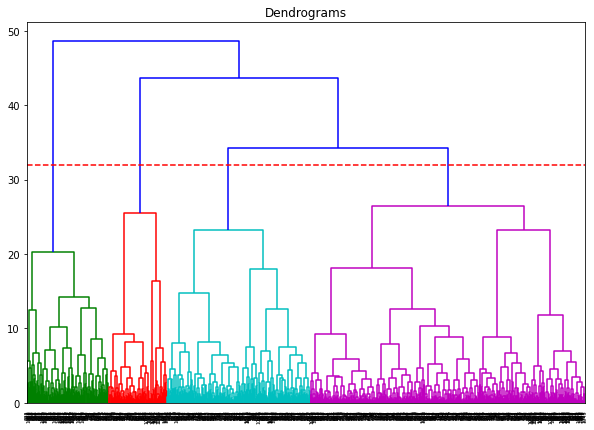

In [ ]:
#@title Create dendogram for hierarchical clustering
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(var_list, method='ward'))
plt.axhline(y=32, color='r', linestyle='--')

From the dendogram, we choose to do 4 clusters. In hierarchical clustering, the aim is to "cut" the tree at the highest branch. We decided to cut the tree with a value of 30 (visualized by the red dashed line). This shows the clear distinctions and similar sizes of the four clusters that we chose. 

Text(0.5, 1.0, 'Hierarchical clustering result')

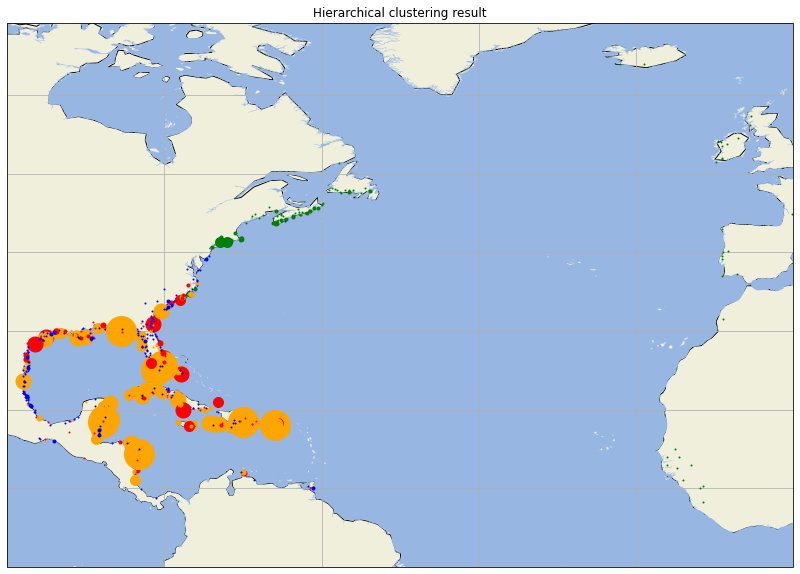

In [ ]:
#@title Perform clustering and add cluster labels to dataset, then plot the cluster landfall locations
cluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')  
cluster.fit_predict(var_list)
labels = cluster.labels_
labels = xr.DataArray(labels,dims='storm',coords={'storm':tks_onland.storm})
tks_clustered_h = tks_onland.assign(labels=labels)
tks_clustered_h
h_clusters = 4
ax = map_background()

colors = ['blue', 'orange', 'green', 'red', 'purple']
sizes = [1,3,5,10,15,30]
for stormnum in tks_clustered_h.storm:
  storm = tks_clustered_h.sel(storm=stormnum)
  ax.plot(storm.lon_landfall, storm.lat_landfall, c=colors[storm.labels.values], 
        marker = 'o', markersize=sizes[int(storm.init_windspeed.values)])
plt.title('Hierarchical clustering result')


From this map, we can see the four different clusters. This shows clusters 0-3 in blue, orange, green, and red, respectively, at the site of landfall. In addition, the size and shape of the markers dependent on the normalized windspeed. 

This map shows us that while there is some clustering based on geography, that is not the most important variable in our algorithm.

## Section 3: Understanding our clusters
We refer to a study by Weinkle et al. (2018) which calculated normalized hurricane damage in the continental United States. We look up our clustered hurricanes to see which ones caused the most damage. This limits the scope of our analysis to hurricanes that made landfall in the continental USA between 1950 and 2017. 

Text(0, 0.5, 'Normalized damage (billions 2018 USD)')

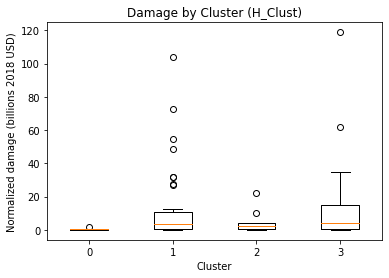

In [ ]:
#@title Visualizing damage per cluster
url = 'https://raw.githubusercontent.com/katelmarsh/hurricanes_climate_pred/main/damage_data.csv'
damage_data = pd.read_csv(url)
labels_for_damage = []
for i in range(len(damage_data)):
  name = damage_data['Storm Name'][i].upper().encode('ascii')
  year = int(damage_data['Year'][i])
  filt_name = tks_clustered_h.where(tks_clustered_h.name==name,drop=True)
  filt_year = filt_name.where(tks_clustered_h.season==year,drop=True)
  if len(filt_year.storm) == 1:
    labels_for_damage.append(int(filt_year.labels.values))
  else:
    labels_for_damage.append(-1)
damage_data['label_h'] = labels_for_damage
h_clust = []
for i in range(h_clusters):
    temp = damage_data[damage_data['label_h']==i]
    temp_list = list(temp["CL2018"]/1e9)
    h_clust.append(temp_list)

fig, axs = plt.subplots(1)
axs.boxplot(h_clust)
axs.set_title('Damage by Cluster (H_Clust)')
plt.xticks([1, 2, 3, 4], [0, 1, 2, 3])
plt.xlabel("Cluster")
plt.ylabel("Normalized damage (billions 2018 USD)")

Examining the box plots, it looks like the majority of hurricanes do the same amount of normalized damage. However, we see that clusters 1 and 3 have high damage outliers as opposed to clusters 0 and 2.

#Revisiting Map Above with Damage 
Along the East Coast, we have the presence of all four of our clusters, showing that we have a representation of both the hurricanes that will hit in an urban area and cause a lot of damage and hurricanes that that will hit in the same place and not cause as much damage. 

Cluster 1 appears to have a large influence from windspeed; however, Cluster 1 (despite having the largest windspeeds seen from size of marker) does not have the highest outliers which are in the red cluser 3. The red cluster 3 has more variance in damage. 

**What we find is that damage is not based on just initial windspeed, which would make both the red and orange circles (cluster 1 and 3) large in the map above.**

Text(0.5, 1.0, 'Change in Count of Hurricanes over Time in Hierarchical-Clusters')

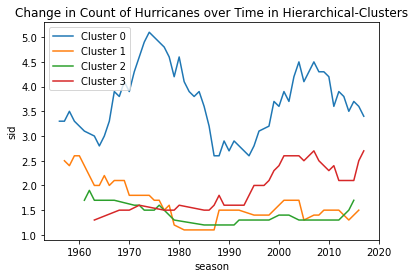

In [ ]:
#@title Counts of each cluster over time
# Plot counts of clusters over time

for label in range(h_clusters):
  temp = tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season>int(1950),drop=True)
  counts = temp.groupby('season').count()
  counts.sid.rolling(season=10, center=True).mean().plot(label=f"Cluster {label}")
plt.legend()
plt.title("Change in Count of Hurricanes over Time in Hierarchical-Clusters")

# We have increase in the cluster (3) that has highly damaging outliers but not the highest windspeeds. Why does this happen? Let's find out. 

What is different about cluster 3? Below, we see that cluster 3 has consistently the highest amount of distance on land. 

In [ ]:
#@title Hierarchical cluster performance on distance on land 

for label in range(h_clusters):
   temp=tks_clustered_h.where(tks_clustered_h.season>int(1950),drop=True)
   temp=temp.where(tks_clustered_h.labels==label,drop=True)
   plt.scatter(temp.season,temp.dist_on_land,label=f"Cluster {label}")
plt.title("Relationship between Distance on land and year")

plt.legend()


From these clusters, we found that one leading characteristic that defined how much damage a hurricane causes is the distance of the track that the hurricane travels on land. Cluster 3 (red) consistently had the highest distance traveled on land. Cluster 1, while damaging, does not appear to travel far on land.

This points to two distinct types of damaging hurricanes:
1. cluster 1: less distance on land, higher initial windspeed
2. cluster 3: more distance on land, lower initial windspeed

# What are the characteristics that make these outliers particularly damaging?

Let's start by looking at sea surface temperature anomalies in the month of hurricane formation. These show that anomalies are rising for all four clusters. This shows that it must not just be the sea surface temperature causing this trend. 

This is confusing becasue cluster 3 is rising in damage while the others are not. 

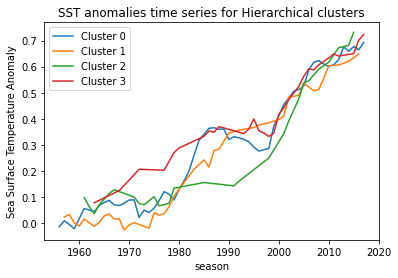

In [ ]:
#@title SST anomalies time series for Hierarchical cluster

for label in range(h_clusters):
  temp =  tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season>int(1950),drop=True)
  mean = temp.groupby('season').mean()
  mean.anomalies.rolling(season=10, center=True).mean().plot(label=f"Cluster {label}") 
plt.title("SST anomalies time series for Hierarchical clusters")
plt.ylabel("Sea Surface Temperature Anomaly")
plt.legend()

Looking at the months of the year, we can see something that enlightens us. 

It is not just that sea surface temperature is rising. It looks like sea surface temperature rising in later months of the year, such as September and October corresponds to specifically cluster 3-type hurricanes happening with higher frequency. 

Hurricanes in cluster 3, which travel further distances over land and can cause large amounts of damage, are becoming more frequent. Combining the month and SST time series graphs, it appears that a rising SST might correspond to the tendency for hurricanes later in the year. The hurricanes in cluster 1 are hapening later in the year in September and October, whiile the hurricnaes in cluster 3 are happening earlier. 



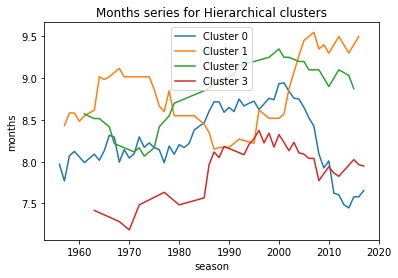

In [ ]:
#@title SST anomalies time series for Hierarchical cluster

for label in range(h_clusters):
  temp =  tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season>int(1950),drop=True)
  mean = temp.groupby('season').mean()
  mean.months.rolling(season=10, center=True).mean().plot(label=f"Cluster {label}") 
plt.title("Months series for Hierarchical clusters")

plt.legend()

86    2005
Name: Year, dtype: int64


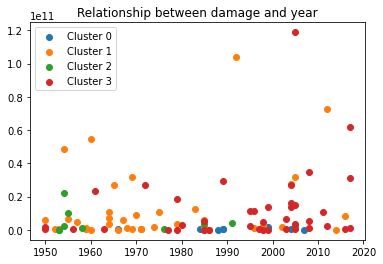

In [ ]:
#@title Pull out the year of the most outlier
for label in range(h_clusters): 
   temp=damage_data[damage_data['label_h']==label]
   plt.scatter(temp.Year,temp.CL2018,label=f"Cluster {label}")
plt.title("Relationship between damage and year")
plt.legend()
temp=damage_data[damage_data['label_h']==3]
max=damage_data[damage_data['label_h']==3].CL2018.max()
print(temp[temp.CL2018==max]['Year'])

Here we see Hurricane Andrew (1992) and Hurricane Katrina (2005) as the high outliers in cluster 1 and 3. 

To try to find the most important components in each cluster, we conducted a principal component analysis. 

In [ ]:
#@title Principle Component Analysis
def get_var(storm):
      dist_on_land = storm.dist_on_land.values
      travel_times = storm.travel_times.values
      min_speed_land = storm.min_speed_land.values
      max_speed_land = storm.max_speed_land.values
      init_windspeed = storm.init_windspeed.values
      month = storm.months.values
      mean_speed_land = storm.mean_speed_land.values
      return dist_on_land,travel_times,min_speed_land,max_speed_land, init_windspeed,month,mean_speed_land

data=[]
for stormnum in tks_clustered_h.storm:
  storm = tks_clustered_h.sel(storm=stormnum)
  row_data = []
  dist_on_land,travel_times,min_speed_land,max_speed_land, init_windspeed,month,mean_speed_land=get_var(storm)
  row_data = [dist_on_land,travel_times,min_speed_land,max_speed_land, init_windspeed,month,mean_speed_land]
  data.append(row_data) 

initial_df = pd.DataFrame(data,columns=['dist_on_land','travel_times','min_speed_land','max_speed_land', 'init_windspeed','month','mean_speed_land'])
pca_df = StandardScaler().fit_transform(initial_df)


pca = PCA()
pca.fit(pca_df)

pca = PCA(n_components=2)
df_reduced = pca.fit_transform(pca_df)
df_original_data = pca.inverse_transform(df_reduced)
new_1=[]
new_2=[]
for i in range(len(df_reduced)):
  new_1.append(df_reduced[i][0])
  new_2.append(df_reduced[i][1])

In [ ]:
#@title Adding the PCA new variables into our dataset
new_1=xr.DataArray(new_1,dims='storm',coords={'storm':tks_onland.storm})
new_2=xr.DataArray(new_2,dims='storm',coords={'storm':tks_onland.storm})

tks_clustered_h_PCA = tks_clustered_h.assign(new_1=new_1,new_2=new_2)

In [ ]:
#@title PCA Matrix
comp=pca.components_
print(comp)

[[ 0.24935229  0.21673482  0.30437444  0.52382144  0.50356943  0.07970066
   0.51369483]
 [-0.58630134 -0.61385493  0.38563976 -0.01771042  0.0490531   0.26113402
   0.24454857]]


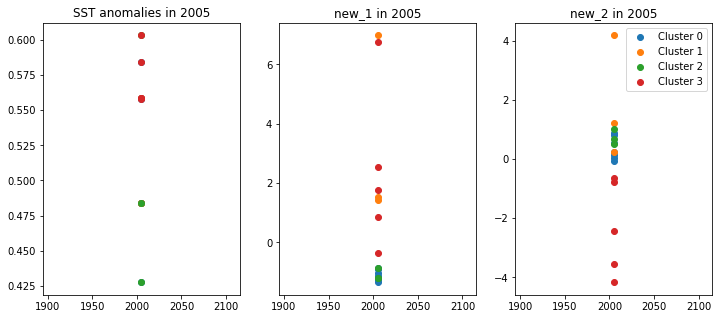

In [ ]:
#@title Overall Comparision on outliers
fig, axs = plt.subplots(1, 3)
for label in range(h_clusters):  
    temp=tks_clustered_h_PCA.where(tks_clustered_h_PCA.labels==label,drop=True).where(tks_clustered_h_PCA.season==int(2005),drop=True)
    axs[0].scatter(temp.season,temp.anomalies,label=f"Cluster {label}")
axs[0].set_title('SST anomalies in 2005')  
for label in range(h_clusters):  
    temp=tks_clustered_h_PCA.where(tks_clustered_h_PCA.labels==label,drop=True).where(tks_clustered_h_PCA.season==int(2005),drop=True)
    axs[1].scatter(temp.season,temp.new_1,label=f"Cluster {label}")
axs[1].set_title('new_1 in 2005')    
for label in range(h_clusters):  
    temp=tks_clustered_h_PCA.where(tks_clustered_h_PCA.labels==label,drop=True).where(tks_clustered_h_PCA.season==int(2005),drop=True)
    axs[2].scatter(temp.season,temp.new_2,label=f"Cluster {label}")
axs[2].set_title('new_2 in 2005')    
plt.legend()
fig.set_size_inches(12, 5)

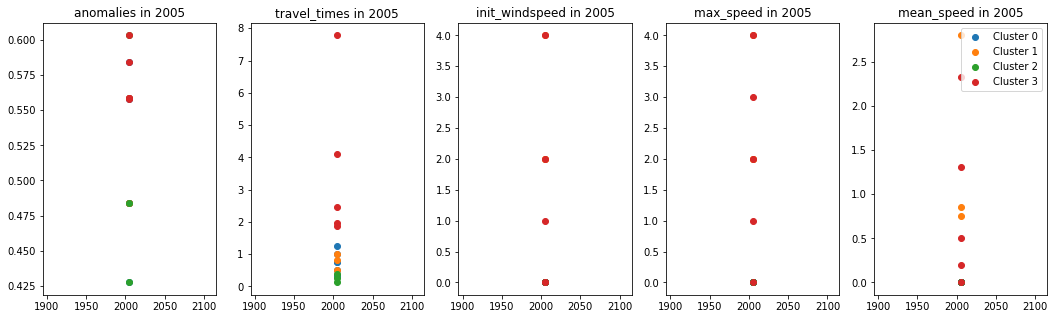

In [ ]:
#@title Outlier Variables Comparison
fig, axs = plt.subplots(1, 5)
for label in range(h_clusters):  
    temp=tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season==int(2005),drop=True)
    axs[0].scatter(temp.season,temp.anomalies,label=f"Cluster {label}")
axs[0].set_title('anomalies in 2005')  
for label in range(h_clusters):  
    temp=tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season==int(2005),drop=True)
    axs[1].scatter(temp.season,temp.travel_times,label=f"Cluster {label}")
axs[1].set_title('travel_times in 2005')    
for label in range(h_clusters):  
    temp=tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season==int(2005),drop=True)
    axs[2].scatter(temp.season,temp.init_windspeed,label=f"Cluster {label}")  
axs[2].set_title('init_windspeed in 2005')
for label in range(h_clusters):  
    temp=tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season==int(2005),drop=True)
    axs[3].scatter(temp.season,temp.max_speed_land,label=f"Cluster {label}")  
axs[3].set_title('max_speed in 2005')
for label in range(h_clusters):  
    temp=tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season==int(2005),drop=True)
    axs[4].scatter(temp.season,temp.mean_speed_land,label=f"Cluster {label}")  
axs[4].set_title('mean_speed in 2005')
plt.legend()
fig.set_size_inches(18, 5)

After this analysis, we conducted a principal component analysis to try to identify why certain outliers happened in our different clusters. We were able to find that the outliers have a relationship with sea surface temperature. In our cluster 3, which usually does not have the highest damage but includes high outliers in the dataset, the sea surface temperature anomalies correspond with their increased damage more than any of the other variables in the dataset. This shows that when a hurricane might cause an average amount of damage, being formed during a sea surface temperature anomaly could take it from being a Hurricane Henri to a Hurricane Ida. 

##References
Boyin Huang, Peter W. Thorne, Viva F. Banzon, Tim Boyer, Gennady Chepurin, Jay H. Lawrimore, Matthew J. Menne, Thomas M. Smith, Russell S. Vose, and Huai-Min Zhang (2017): NOAA Extended Reconstructed Sea Surface Temperature (ERSST), Version 5. *NOAA National Centers for Environmental Information*. doi:10.7289/V5T72FNM

Dare, R., & McBride, J. (2011). The Threshold Sea Surface Temperature Condition for Tropical Cyclogenesis. *Journal Of Climate*, 24(17), 4570-4576. doi: 10.1175/jcli-d-10-05006.1

Knapp, K. R., M. C. Kruk, D. H. Levinson, H. J. Diamond, and C. J. Neumann, 2010. The International Best Track Archive for Climate Stewardship (IBTrACS): Unifying tropical cyclone best track data. *Bulletin of the American Meteorological Society*, 91, 363-376. doi:10.1175/2009BAMS2755.1

McNulty, I. (2022, January 19). What's ahead for restaurants, bars closed since Hurricane Ida? answers vary widely. NOLA.com. Retrieved February 5, 2022, from https://www.nola.com/entertainment_life/eat-drink/article_699723b2-74bc-11ec-8d6d-0ba9ad05bd40.html 

Newman, A., & Ferré-Sadurní, L. (2021, November 12). As ida deaths rise, N.Y. leaders look toward future storms. The New York Times. Retrieved February 5, 2022, from https://www.nytimes.com/live/2021/09/03/nyregion/nyc-flooding-ida#:~:text=Even%20so%2C%20state%20leaders%20said,people%20were%20still%20without%20electricity. 

Weinkle, J., Landsea, C., Collins, D., Musulin, R., Crompton, R., Klotzbach, P., & Pielke, R. (2018). Normalized hurricane damage in the continental United States 1900–2017. *Nature Sustainability*, 1(12), 808-813. doi: 10.1038/s41893-018-0165-2

##Appendix

Here, we show the code that influenced but was not in the final version of the story, including our different clustering analyses and some extra graphs.

Text(0.5, 1.0, 'Inertia Values against the Number of Cluster k')

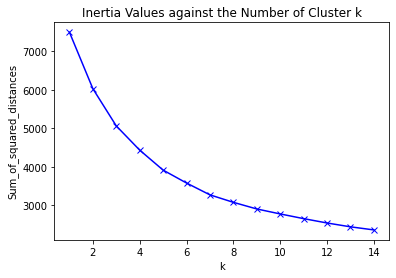

In [ ]:
#@title
sum_of_squares = []
K = range(1, 15)
for k in K:
    km = k_means(var_list, n_clusters=k)
    sum_of_squares.append(km[2])
plt.plot(K, sum_of_squares, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Inertia Values against the Number of Cluster k')

In [ ]:
#@title
n_clusters=5
km = k_means(var_list, n_clusters=n_clusters)
labels = km[1]
labels = xr.DataArray(labels,dims='storm',coords={'storm':tks_onland.storm})

tks_clustered = tks_onland.assign(labels=labels)
tks_clustered

<xarray.Dataset>
Dimensions:          (storm: 1070)
Coordinates:
  * storm            (storm) int64 0 1 5 7 9 14 ... 2284 2285 2288 2291 2292
Data variables: (12/16)
    dist_on_land     (storm) float64 514.2 432.7 2.158e+03 ... 178.5 125.8 66.46
    travel_times     (storm) float64 2.0 1.375 3.125 0.25 ... 0.25 0.25 0.125
    min_speed_land   (storm) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    mean_speed_land  (storm) float64 0.1176 0.0 0.5172 0.0 ... 0.0 0.0 0.0 0.0
    max_speed_land   (storm) float64 1.0 0.0 2.0 0.0 0.0 ... 1.0 0.0 0.0 0.0 0.0
    lat_landfall     (storm) float64 28.17 19.8 18.53 22.1 ... 10.3 31.3 9.88
    ...               ...
    number           (storm) float64 5.0 6.0 10.0 12.0 ... 73.0 76.0 88.0 90.0
    name             (storm) object b'NOT_NAMED' b'NOT_NAMED' ... b'TERRY'
    sid              (storm) object b'1851175N26270' ... b'2021306N10279'
    months           (storm) float64 6.0 6.0 8.0 9.0 9.0 ... 9.0 9.0 10.0 11.0
    anomalies        (storm) float64 0.0 0.0 0.0 0.0 ... 0.9712 0.8992 0.8653
    labels           (storm) int32 3 3 0 4 4 4 1 3 4 4 4 ... 2 2 0 2 0 0 2 2 4 4
Attributes: (12/50)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r00
    ...                         ...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    nco_openmp_thread_number:   1
    NCO:                        4.4.3

Text(0.5, 1.0, 'K-means clustering result')

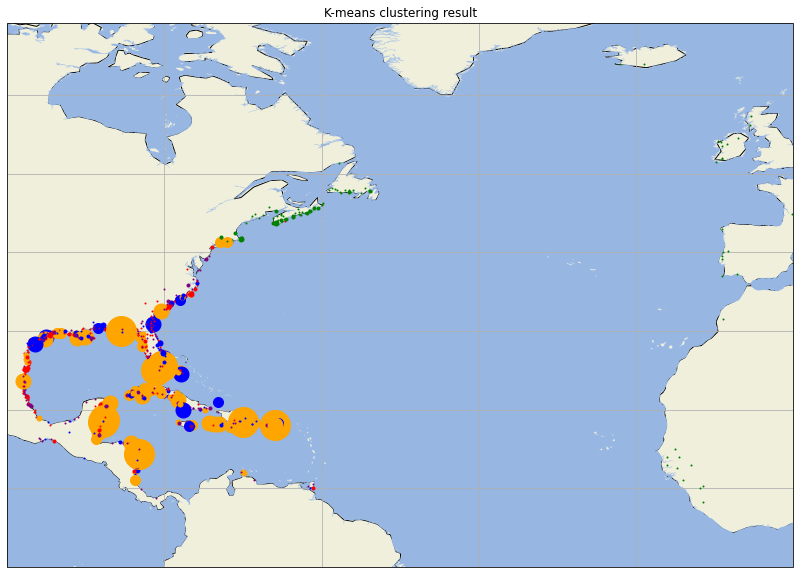

In [ ]:
#@title
# Look at landfall locations
def map_background(label=False, extent=[-100, 0, 0, 60]):
  # A helpder function for creating the map background.
  # INPUT:
  # "extent": corresponds to the location information of the showed map.
  # "label": boolean

  # OUTPUT:
  # Matplotlib AXES object

  plt.figure(figsize = (20, 10))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.coastlines()
  ax.set_extent(extent)
  ax.gridlines(draw_labels=label) # show labels or not
  LAND = cfeature.NaturalEarthFeature('physical', 'land', '10m', 
                                      edgecolor='face', 
                                      facecolor=cfeature.COLORS['land'],
                                          linewidth=.1)
  OCEAN = cfeature.NaturalEarthFeature('physical', 'ocean', '10m',
                                       edgecolor='face', 
                                       facecolor=cfeature.COLORS['water'], linewidth=.1)
  ax.add_feature(LAND, zorder=0)
  ax.add_feature(OCEAN)
  return ax
ax = map_background()

colors = ['blue', 'orange', 'green', 'red', 'purple']
sizes = [1,3,5,10,15,30]
for stormnum in tks_clustered.storm:
  storm = tks_clustered.sel(storm=stormnum)
  ax.plot(storm.lon_landfall, storm.lat_landfall, c=colors[storm.labels.values], 
        marker='o',markersize=sizes[int(storm.init_windspeed.values)])
plt.title('K-means clustering result')

In [ ]:
#@title
labels_for_damage = []
for i in range(len(damage_data)):
  name = damage_data['Storm Name'][i].upper().encode('ascii')
  year = int(damage_data['Year'][i])
  filt_name = tks_clustered.where(tks_clustered.name==name,drop=True)
  filt_year = filt_name.where(tks_clustered.season==year,drop=True)
  if len(filt_year.storm) == 1:
    labels_for_damage.append(int(filt_year.labels.values))
  else:
    labels_for_damage.append(-1)

damage_data['label_k'] = labels_for_damage

Text(0.5, 1.0, 'Change in Count of Hurricanes over Time in K-means Clusters')

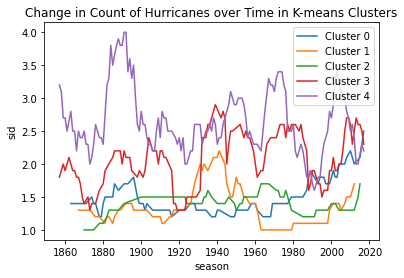

In [ ]:
#@title
# Plot counts of clusters over time

for label in range(n_clusters):
  temp = tks_clustered.where(tks_clustered.labels==label,drop=True)
  counts = temp.groupby('season').count()
  counts.sid.rolling(season=10, center=True).mean().plot(label=f"Cluster {label}")
plt.legend()
plt.title("Change in Count of Hurricanes over Time in K-means Clusters")

Text(0, 0.5, 'Normalized damage (billions 2018 USD)')

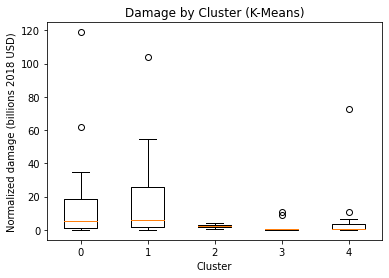

In [ ]:
#@title
k_clust = []
for i in range(n_clusters):
    temp = damage_data[damage_data['label_k']==i]
    temp_list = list(temp["CL2018"]/1e9)
    k_clust.append(temp_list)
bp = plt.boxplot(k_clust)
plt.title('Damage by Cluster (K-Means)')
plt.xticks([1, 2, 3, 4, 5], [0, 1, 2, 3, 4])
plt.xlabel("Cluster")
plt.ylabel("Normalized damage (billions 2018 USD)")

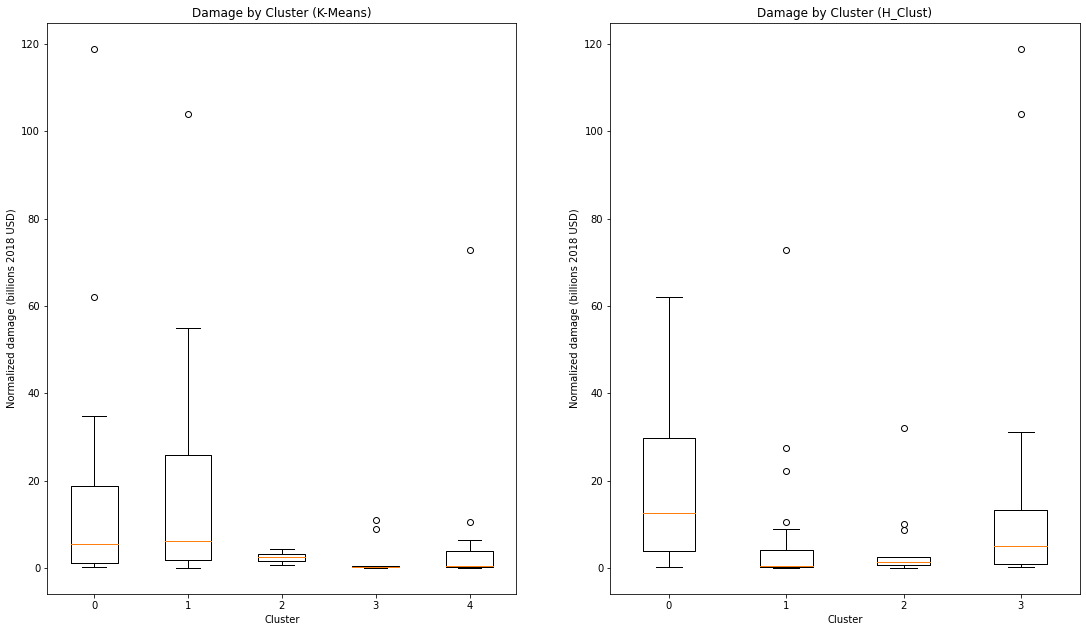

In [ ]:
#@title Comparing k-means and hierarchical clustering
from matplotlib.pyplot import figure

fig, axs = plt.subplots(1, 2)
axs[0].boxplot(k_clust)
axs[0].set_title('Damage by Cluster (K-Means)')
axs[0].set_xticklabels([0, 1, 2, 3, 4])
axs[0].set_xlabel("Cluster")
axs[0].set_ylabel("Normalized damage (billions 2018 USD)")

axs[1].boxplot(h_clust)
axs[1].set_title('Damage by Cluster (H_Clust)')
axs[1].set_xticklabels([0, 1, 2, 3])
axs[1].set_xlabel("Cluster")
axs[1].set_ylabel("Normalized damage (billions 2018 USD)")


fig.set_size_inches(18.5, 10.5)

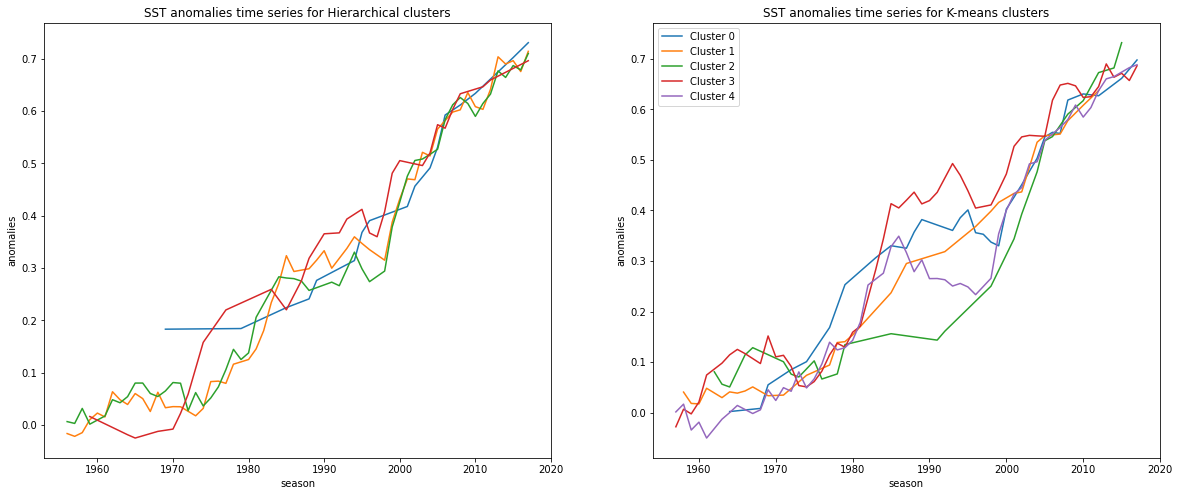

In [ ]:
#@title Time series for each kinds of cluster
title = ["Hierarchical clusters","K-means clusters"]
fig, axes = plt.subplots(1, 2)
for label in range(h_clusters):
  temp =  tks_clustered_h.where(tks_clustered_h.labels==label,drop=True).where(tks_clustered_h.season>int(1950),drop=True)
  mean = temp.groupby('season').mean()
  mean.anomalies.rolling(season=10, center=True).mean().plot(ax=axes[0],label=f"Cluster {label}") 
axes[0].set_title("SST anomalies time series for {}".format(title[0]))
for label in range(n_clusters):
  temp = tks_clustered.where(tks_clustered.season>int(1950),drop=True).where(tks_clustered.labels==label,drop=True)
  mean = temp.groupby('season').mean()
  mean.anomalies.rolling(season=10, center=True).mean().plot(ax=axes[1],label=f"Cluster {label}") 
axes[1].set_title("SST anomalies time series for {}".format(title[1]))
plt.legend()

fig.set_size_inches(20, 8)

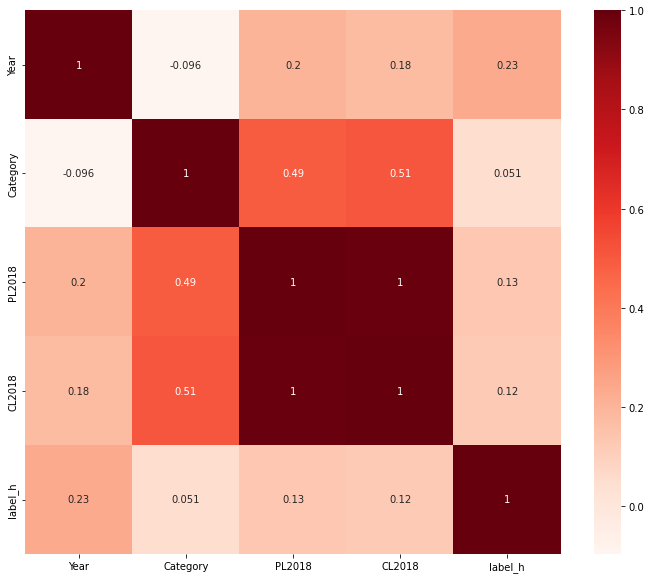

In [ ]:
import seaborn as sns
#Using Pearson Correlation
plt.figure(figsize=(12,10))
cor = damage_data.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()